# Installation and Setup

In [10]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cpu


# Create a dataloader

In [11]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)


    return W

class TrafficDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'PeMSD7_V_228.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        copyfile('./dataset/PeMSD7_V_228.csv', os.path.join(self.raw_dir, 'PeMSD7_V_228.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))
        
        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        # manipulate nxn matrix into 2xnum_edges
        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1

        # using resize_ to just keep the first num_edges entries
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []
        # T x F x N
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                # (F,N) switched to (N,F)
                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window
                # [21, 228]
                full_window = np.swapaxes(data[sta:end, :], 0, 1)
                g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)

        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

def get_splits(dataset: TrafficDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: TrafficDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test

# Build the model

In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        print(x)
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        
        return x


## Create Train and Evaluation functions

In [39]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                print(y_pred.shape)
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
    
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n
    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')  
    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In [14]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))


In [25]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT']) 
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


## Start training

%load_ext tensorboard
%tensorboard --logdir ./runs

In [26]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 6, # 60 default
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = TrafficDataset(config, W)


In [27]:
# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node

Using cpu


In [40]:
model = model_train(train_dataloader, val_dataloader, config, device)

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

tensor([[ 0.8315,  0.8685,  0.8389,  ...,  0.8389,  0.9056,  0.7573],
        [ 1.0985,  0.5867,  0.8092,  ...,  0.7795,  0.7350,  0.8982],
        [-0.1327, -0.1179,  0.0676,  ...,  0.0453,  0.0898,  0.2307],
        ...,
        [ 0.2826,  0.3271,  0.2604,  ...,  0.1936,  0.2085,  0.1862],
        [ 0.0972,  0.1343,  0.1417,  ...,  0.0231,  0.0898,  0.1862],
        [-0.1179,  0.1343,  0.1936,  ...,  0.4903,  0.5496,  0.5645]])
torch.Size([11400, 9])


Epoch 0:   1%|          | 2/183 [00:00<00:37,  4.89it/s]

tensor([[-2.2168, -2.4022, -2.4838,  ..., -2.8101, -2.5653, -2.6321],
        [ 0.9724,  0.8315,  0.9279,  ...,  0.7425,  0.7499,  0.5719],
        [-1.9794, -2.2909, -2.3058,  ..., -1.5493, -1.2749, -1.3119],
        ...,
        [ 0.6609,  0.6757,  0.6980,  ...,  0.7054,  0.8018,  0.8908],
        [ 0.6312,  0.6831,  0.7276,  ...,  0.6831,  0.6831,  0.6238],
        [ 0.7202,  0.7128,  0.6386,  ...,  0.7054,  0.7054,  0.7202]])
torch.Size([11400, 9])
tensor([[ 0.0082, -0.0066, -0.0734,  ...,  0.0453,  0.1195,  0.0972],
        [ 0.8982,  0.9205,  0.7202,  ...,  1.2320,  0.9130,  1.1281],
        [ 0.7128,  0.6905,  0.6905,  ...,  0.4532,  0.4310,  0.5496],
        ...,
        [-1.0079, -1.0301, -0.9634,  ..., -0.1698, -0.1772, -0.3107],
        [-3.0623, -2.7433, -2.7953,  ..., -1.5493, -1.6902, -2.1129],
        [ 0.0156, -0.0659, -0.1846,  ...,  0.1714,  0.2752,  0.2530]])


Epoch 0:   2%|▏         | 3/183 [00:00<00:32,  5.48it/s]

torch.Size([11400, 9])
tensor([[-2.2835, -1.5196, -1.8237,  ..., -1.2749, -0.8892, -0.4219],
        [-2.7063, -3.0623, -3.2773,  ..., -2.2464, -2.6173, -2.3132],
        [ 0.7870,  0.8463,  0.9056,  ...,  0.8166,  0.8760,  0.8463],
        ...,
        [ 0.0750,  0.0082, -0.0437,  ...,  0.0156,  0.0601, -0.0066],
        [ 0.1417, -0.0066,  0.0379,  ...,  0.0156, -0.0066,  0.0082],
        [ 0.2975,  0.2011,  0.2530,  ..., -0.2736, -0.6370, -0.6741]])
torch.Size([11400, 9])


Epoch 0:   3%|▎         | 5/183 [00:00<00:26,  6.62it/s]

tensor([[ 0.9501,  1.2171,  1.2023,  ...,  0.4235,  0.4235,  0.3642],
        [ 0.7870,  0.6386,  0.7350,  ...,  0.6831,  0.5867,  0.5200],
        [ 0.9724,  1.0391,  1.0391,  ..., -0.5777, -0.5703, -1.1265],
        ...,
        [ 0.6609,  0.6831,  0.7350,  ...,  0.6683,  0.5348,  0.6905],
        [ 0.6460,  0.7128,  0.7276,  ...,  0.5645,  0.4310,  0.6831],
        [ 0.4087,  0.4013,  0.4310,  ...,  0.4977,  0.5051,  0.4755]])
torch.Size([11400, 9])
tensor([[-2.1055, -1.2971, -0.4887,  ...,  0.6683,  0.5793,  0.4235],
        [ 0.3049,  0.3865,  0.3271,  ...,  0.3865,  0.2381,  0.2381],
        [-1.7718, -1.7495, -1.7273,  ..., -0.6889, -0.6815, -0.8966],
        ...,
        [ 0.0750,  0.0453,  0.1046,  ...,  0.1195,  0.2307,  0.2455],
        [ 0.2826,  0.2678,  0.2233,  ...,  0.2900,  0.3865,  0.3049],
        [-0.8150, -0.5184, -0.2810,  ..., -0.2588, -0.2143, -0.0437]])
torch.Size([11400, 9])


Epoch 0:   4%|▍         | 7/183 [00:01<00:26,  6.61it/s]

tensor([[ 7.3505e-01,  7.7213e-01,  8.0179e-01,  ...,  5.8671e-01,
          6.6830e-01,  8.2404e-01],
        [ 5.7930e-01,  6.1638e-01,  1.0910e+00,  ...,  4.0872e-01,
          4.2355e-01,  2.6038e-01],
        [ 6.7571e-01,  4.5321e-01,  3.9388e-01,  ...,  2.1588e-01,
          1.3430e-01,  1.5655e-01],
        ...,
        [-6.5947e-02,  1.0463e-01,  3.7885e-02,  ..., -4.3697e-02,
          4.5302e-02, -8.0780e-02],
        [ 8.9801e-02,  4.5302e-02,  7.4968e-02,  ...,  1.5635e-02,
          4.5302e-02,  8.0218e-04],
        [ 2.3072e-01,  2.6038e-01,  1.9363e-01,  ...,  2.3072e-01,
          2.3813e-01,  3.2713e-01]])
torch.Size([11400, 9])
tensor([[0.1491, 0.0601, 0.1269,  ..., 0.2011, 0.3271, 0.3271],
        [0.7647, 0.7573, 0.6757,  ..., 0.9427, 1.3358, 1.0836],
        [1.0540, 1.2394, 1.1133,  ..., 0.4606, 0.7721, 0.7499],
        ...,
        [0.6535, 0.5941, 0.5941,  ..., 0.7499, 0.7944, 0.6757],
        [0.6535, 0.7128, 0.6609,  ..., 0.8611, 0.8092, 0.7128],
        [0.2

Epoch 0:   5%|▍         | 9/183 [00:01<00:24,  7.08it/s]

tensor([[-2.8620, -3.0845, -2.8472,  ...,  0.1862,  0.4087,  0.4310],
        [-3.5147, -3.3663, -3.5147,  ..., -3.3070, -3.3441, -3.2403],
        [ 0.7054,  0.6905,  0.7425,  ...,  0.8092,  0.8315,  0.8018],
        ...,
        [ 0.3420,  0.3865,  0.3271,  ...,  0.4755,  0.4829,  0.4310],
        [ 0.2530,  0.2678,  0.2900,  ...,  0.5051,  0.5422,  0.5200],
        [-0.6222, -0.5480, -0.5035,  ..., -0.6519, -0.5035, -0.6074]])
torch.Size([11400, 9])
tensor([[ 0.2900,  0.0676,  0.3049,  ..., -0.0808, -0.2959, -0.2736],
        [-2.2019, -0.7409,  0.0231,  ...,  0.4384,  0.4310,  0.4903],
        [ 0.1195, -0.0808, -0.1030,  ..., -1.3787, -1.6531, -1.7273],
        ...,
        [ 0.2085,  0.1788,  0.2530,  ...,  0.1491,  0.0972,  0.1417],
        [ 0.2900,  0.2455,  0.2975,  ...,  0.1566,  0.2381,  0.2604],
        [ 0.1862,  0.3271,  0.4977,  ...,  0.6609,  0.5422,  0.5422]])
torch.Size([11400, 9])


Epoch 0:   6%|▌         | 11/183 [00:01<00:24,  7.06it/s]

tensor([[ 0.1195,  0.0231,  0.0527,  ...,  0.0824,  0.0750, -0.1179],
        [ 0.6831,  0.6312,  0.5570,  ...,  0.9946,  0.8685,  0.9946],
        [ 0.4532,  0.5274,  0.6980,  ...,  0.5348,  0.5422,  0.4680],
        ...,
        [ 0.4384,  0.4977,  0.5719,  ...,  0.3790,  0.3642,  0.4310],
        [ 0.3123,  0.3865,  0.3790,  ...,  0.1788,  0.1788,  0.1714],
        [ 0.4977,  0.4087,  0.3345,  ...,  0.2900,  0.3790,  0.3865]])
torch.Size([11400, 9])
tensor([[ 0.5496,  0.5941,  0.5200,  ..., -1.4084, -1.9275, -2.2835],
        [ 0.6683,  0.5645,  0.7054,  ...,  0.6386,  0.6460,  0.7425],
        [-1.2600, -1.5048, -1.6457,  ..., -1.4380, -1.6383, -1.2749],
        ...,
        [ 0.6683,  0.5793,  0.5719,  ...,  0.8685,  0.8463,  0.8389],
        [ 0.6460,  0.5793,  0.6905,  ...,  0.8908,  0.8389,  0.8240],
        [ 0.8018,  0.6535,  0.6905,  ...,  0.7573,  0.7128,  0.7350]])
torch.Size([11400, 9])


Epoch 0:   7%|▋         | 13/183 [00:01<00:23,  7.35it/s]

tensor([[-2.3577, -2.2983, -2.5357,  ..., -2.5728, -0.4442, -1.1636],
        [ 0.4903,  0.5422,  0.4235,  ..., -2.1648, -2.7804, -2.8249],
        [-0.0956,  0.0453,  0.1788,  ..., -0.2514, -0.1624, -0.1475],
        ...,
        [ 0.6535,  0.6164,  0.4755,  ...,  0.7350,  0.8315,  0.9353],
        [ 0.5274,  0.3790,  0.4458,  ...,  0.6609,  0.7350,  0.9279],
        [ 0.7944,  0.7425,  0.8463,  ...,  0.8834,  0.7795,  0.6757]])
torch.Size([11400, 9])
tensor([[0.7499, 0.9205, 0.8389,  ..., 0.7721, 1.0020, 0.7054],
        [1.2245, 1.1133, 1.1059,  ..., 0.8092, 1.0762, 1.0391],
        [0.4087, 0.4013, 0.1121,  ..., 0.6831, 0.5793, 0.5200],
        ...,
        [0.3345, 0.2011, 0.3197,  ..., 0.5645, 0.5719, 0.6905],
        [0.1343, 0.1343, 0.1343,  ..., 0.4977, 0.4829, 0.5793],
        [0.2975, 0.2975, 0.3568,  ..., 0.3939, 0.4087, 0.3790]])


Epoch 0:   8%|▊         | 14/183 [00:02<00:24,  6.97it/s]

torch.Size([11400, 9])
tensor([[-2.9362e+00, -2.7953e+00, -2.8768e+00,  ..., -2.8323e+00,
         -2.8101e+00, -2.8398e+00],
        [ 9.1304e-01,  8.7596e-01,  7.4988e-01,  ...,  6.5346e-01,
          5.0513e-01,  4.9771e-01],
        [-1.9127e+00, -2.0388e+00, -2.3280e+00,  ..., -4.2936e-01,
         -1.4011e-01, -7.3364e-02],
        ...,
        [-1.1786e-01, -1.4011e-01, -1.7720e-01,  ..., -1.6978e-01,
         -2.3653e-01, -1.6236e-01],
        [-1.2528e-01, -1.2528e-01, -1.2528e-01,  ...,  3.0469e-02,
          8.0218e-04,  1.5635e-02],
        [-1.0303e-01, -3.6281e-02, -7.3364e-02,  ..., -2.8103e-01,
         -3.1069e-01, -3.1069e-01]])
torch.Size([11400, 9])


Epoch 0:   9%|▊         | 16/183 [00:02<00:23,  7.25it/s]

tensor([[1.0762, 1.0465, 1.1281,  ..., 0.7350, 0.8611, 0.9205],
        [0.8315, 0.8315, 0.8240,  ..., 0.7499, 0.7350, 0.8315],
        [0.6831, 0.6609, 0.6980,  ..., 0.6683, 0.7647, 0.6312],
        ...,
        [0.9279, 0.8685, 0.8463,  ..., 0.5274, 0.4977, 0.4829],
        [0.8982, 0.8908, 0.8389,  ..., 0.6312, 0.6312, 0.5645],
        [0.7128, 0.7573, 0.7128,  ..., 0.3420, 0.2752, 0.2307]])
torch.Size([11400, 9])
tensor([[ 0.2233,  0.1936, -0.0437,  ...,  0.1343, -0.1104,  0.0231],
        [ 0.8760,  1.0169,  0.8611,  ...,  0.9056,  0.8611,  0.8092],
        [ 0.6905,  0.6609,  0.8685,  ...,  1.1133,  1.0836,  1.0688],
        ...,
        [ 0.6757,  0.6609,  0.3568,  ...,  0.4829,  0.5200,  0.7647],
        [ 0.6312,  0.5941,  0.5867,  ...,  0.5200,  0.6609,  0.5867],
        [ 0.7944,  0.8463,  0.8240,  ...,  0.8240,  0.8092,  0.8611]])
torch.Size([11400, 9])


Epoch 0:  10%|▉         | 18/183 [00:02<00:22,  7.28it/s]

tensor([[ 0.7721,  0.7944,  0.9130,  ...,  0.6831,  0.6386,  0.5941],
        [ 0.8685,  0.4310,  0.6980,  ...,  0.8908,  0.6164,  0.7870],
        [ 0.2975, -0.0437,  0.0082,  ..., -0.0437, -0.1624, -0.3329],
        ...,
        [-0.0808, -0.1920, -0.1327,  ...,  0.0527, -0.0659, -0.0511],
        [-0.0659,  0.0750,  0.0898,  ...,  0.0156,  0.0676,  0.0824],
        [-0.3181, -0.2884, -0.2662,  ..., -0.2365, -0.2439, -0.3107]])
torch.Size([11400, 9])
tensor([[1.0243, 1.2023, 1.1949,  ..., 0.7128, 0.8685, 0.8389],
        [0.8315, 1.3580, 1.2171,  ..., 0.9205, 0.9650, 0.8166],
        [0.4606, 0.6831, 0.5793,  ..., 0.4384, 0.3790, 0.4161],
        ...,
        [0.4903, 0.4606, 0.6015,  ..., 0.6238, 0.5941, 0.5793],
        [0.3642, 0.2381, 0.3197,  ..., 0.5125, 0.5645, 0.4458],
        [0.4161, 0.4458, 0.4680,  ..., 0.8240, 0.6980, 0.6831]])
torch.Size([11400, 9])


Epoch 0:  11%|█         | 20/183 [00:02<00:21,  7.54it/s]

tensor([[-2.3354, -2.3799, -2.3577,  ..., -0.4145,  0.4087,  0.7944],
        [-3.1958, -3.3293, -3.4776,  ..., -2.6321, -2.8768, -2.7433],
        [-2.9213, -2.7137, -2.5208,  ..., -1.9349, -1.4529, -0.3255],
        ...,
        [ 0.0453,  0.0527, -0.0289,  ...,  0.0453,  0.0972,  0.1046],
        [ 0.1491,  0.1491,  0.0824,  ...,  0.1491,  0.1936,  0.1862],
        [ 0.1121,  0.0824,  0.0305,  ...,  0.0527,  0.0305,  0.0824]])
torch.Size([11400, 9])
tensor([[-0.2810, -0.0437,  0.1046,  ..., -0.6593, -0.4368, -0.2365],
        [-2.3503, -2.5357, -2.3948,  ..., -2.2316, -2.1426, -2.1278],
        [-0.2365, -0.1253, -0.1253,  ...,  0.0527, -0.1104,  0.0972],
        ...,
        [ 0.2604,  0.2975,  0.3790,  ...,  0.2381,  0.3642,  0.3345],
        [ 0.2011,  0.2381,  0.2381,  ...,  0.1269,  0.1714,  0.2678],
        [ 0.0453,  0.1714,  0.3049,  ...,  0.7721,  0.7202,  0.7425]])
torch.Size([11400, 9])


Epoch 0:  12%|█▏        | 22/183 [00:03<00:21,  7.53it/s]

tensor([[ 3.7885e-02,  8.2188e-03, -7.3364e-02,  ...,  3.0469e-02,
          8.2188e-03, -1.1045e-01],
        [ 9.5754e-01,  1.2394e+00,  9.6496e-01,  ...,  1.1207e+00,
          8.5371e-01,  8.6113e-01],
        [ 7.4988e-01,  8.0921e-01,  8.3146e-01,  ...,  1.1281e+00,
          1.1504e+00,  1.2468e+00],
        ...,
        [ 7.4968e-02,  9.7218e-02,  3.7885e-02,  ...,  1.0463e-01,
          8.9801e-02,  8.0218e-04],
        [ 2.5297e-01,  1.9363e-01,  1.3430e-01,  ...,  7.4968e-02,
          1.1205e-01,  1.1205e-01],
        [ 6.3863e-01,  5.2738e-01,  3.7905e-01,  ...,  6.2380e-01,
          6.1638e-01,  5.5705e-01]])
torch.Size([11400, 9])
tensor([[-3.0697, -3.0178, -2.8768,  ..., -3.0548, -3.1661, -2.9881],
        [-3.4257, -3.2551, -3.3738,  ..., -3.2403, -3.4776, -3.5221],
        [-2.1352, -1.9498, -1.7569,  ..., -1.5270, -0.9411, -0.6593],
        ...,
        [ 0.1343,  0.2011,  0.1491,  ...,  0.2530,  0.3197,  0.3494],
        [ 0.2455,  0.2900,  0.2159,  ...,  0.3568,  

Epoch 0:  13%|█▎        | 24/183 [00:03<00:21,  7.49it/s]

tensor([[0.7276, 0.8611, 0.9872,  ..., 0.7721, 0.7276, 0.7795],
        [0.7425, 0.8092, 0.9798,  ..., 1.1133, 0.9427, 0.9650],
        [0.1343, 0.2159, 0.0824,  ..., 0.0453, 0.2085, 0.2678],
        ...,
        [0.6238, 0.5793, 0.7054,  ..., 0.6905, 0.7350, 0.6386],
        [0.6757, 0.6312, 0.6757,  ..., 0.5793, 0.6015, 0.7425],
        [0.4161, 0.4087, 0.5719,  ..., 0.7944, 0.7202, 0.8389]])
torch.Size([11400, 9])
tensor([[-2.1723, -1.8088, -1.0449,  ..., -2.4986, -2.5505, -2.7063],
        [-2.5950, -2.5653, -2.7730,  ..., -3.1809, -3.2996, -2.6469],
        [ 0.1417,  0.1195,  0.1491,  ...,  0.2233,  0.2826,  0.2085],
        ...,
        [ 0.4384,  0.4013,  0.4680,  ...,  0.6757,  0.6980,  0.6164],
        [ 0.5719,  0.6164,  0.6090,  ...,  0.6015,  0.5570,  0.4977],
        [ 0.3197,  0.0676, -0.0214,  ...,  0.7721,  0.8834,  0.6535]])
torch.Size([11400, 9])


Epoch 0:  14%|█▍        | 26/183 [00:03<00:21,  7.39it/s]

tensor([[ 0.4161,  0.7870,  0.9798,  ...,  0.6090,  0.8463,  0.7573],
        [ 0.3865,  0.1714,  0.4977,  ...,  0.5051,  0.6386,  0.8018],
        [ 0.3716,  0.6312,  0.5422,  ...,  0.5348,  0.7128,  0.7425],
        ...,
        [ 0.2678, -0.0363,  0.1417,  ...,  0.3568,  0.6238,  0.4087],
        [ 0.1195,  0.2604,  0.0156,  ...,  0.3049,  0.2752,  0.5719],
        [ 0.7054,  0.7573,  0.6164,  ...,  0.6015,  0.5719,  0.7054]])
torch.Size([11400, 9])
tensor([[1.1059, 0.9130, 0.9872,  ..., 0.9872, 1.0465, 1.1059],
        [0.9501, 1.1800, 1.3061,  ..., 0.5645, 0.4532, 1.1355],
        [0.6460, 0.6386, 0.6980,  ..., 0.8166, 0.6015, 0.5200],
        ...,
        [0.8166, 0.8315, 0.8018,  ..., 0.5051, 0.5570, 0.4680],
        [0.8611, 0.8982, 0.8463,  ..., 0.6090, 0.5645, 0.6015],
        [0.7795, 0.7054, 0.6164,  ..., 0.1269, 0.2233, 0.0972]])
torch.Size([11400, 9])


Epoch 0:  15%|█▌        | 28/183 [00:03<00:20,  7.56it/s]

tensor([[ 6.5346e-01,  8.0179e-01,  2.3813e-01,  ...,  7.4988e-01,
          7.1280e-01,  8.1663e-01],
        [ 1.4693e+00,  1.4396e+00,  1.6621e+00,  ...,  1.4619e+00,
          1.3951e+00,  1.4767e+00],
        [ 9.7238e-01,  9.9463e-01,  9.2046e-01,  ..., -6.5947e-02,
          3.5680e-01,  5.8671e-01],
        ...,
        [-7.3364e-02, -4.3697e-02, -1.0303e-01,  ..., -1.4011e-01,
         -1.7720e-01, -8.8197e-02],
        [-4.3697e-02, -1.9945e-01, -9.5614e-02,  ..., -1.2528e-01,
         -1.2528e-01, -2.8864e-02],
        [ 8.0218e-04, -4.3697e-02, -7.3364e-02,  ..., -3.6281e-02,
         -7.3364e-02, -7.3364e-02]])
torch.Size([11400, 9])
tensor([[ 0.8092,  0.7350,  0.9279,  ...,  1.0169,  0.7944,  0.9427],
        [ 0.7425,  0.5200,  0.4458,  ...,  0.6386,  0.6609,  0.6757],
        [ 0.6238,  0.4755,  0.5274,  ...,  0.5125,  0.6460,  0.5793],
        ...,
        [-0.2143, -0.2884, -0.8669,  ...,  0.0601,  0.0750,  0.0750],
        [-2.6692, -2.5579, -1.1414,  ...,  0.1491,  

Epoch 0:  16%|█▋        | 30/183 [00:04<00:20,  7.35it/s]

tensor([[ 1.1949,  1.0614,  1.2913,  ...,  0.4161,  0.2900, -0.0808],
        [ 0.9056,  1.0169,  0.9798,  ...,  0.5200,  0.5348,  0.6015],
        [ 0.9427,  0.9353,  0.4384,  ..., -1.0969, -1.0375, -1.0820],
        ...,
        [ 0.7054,  0.7350,  0.6164,  ...,  0.6386,  0.6980,  0.8018],
        [ 0.6386,  0.7499,  0.5422,  ...,  0.7202,  0.7795,  0.7276],
        [ 0.3939,  0.3790,  0.3716,  ...,  0.3568,  0.3716,  0.3790]])
torch.Size([11400, 9])
tensor([[0.9353, 0.8092, 0.9650,  ..., 1.0540, 1.0169, 0.9650],
        [0.8982, 0.6905, 0.7350,  ..., 1.0020, 1.0836, 1.2320],
        [0.7425, 0.8982, 0.8685,  ..., 0.5941, 0.7202, 0.8240],
        ...,
        [0.7944, 0.8018, 0.7721,  ..., 0.5719, 0.5867, 0.6015],
        [0.8611, 0.8685, 0.9130,  ..., 0.8834, 0.7573, 0.6905],
        [0.6609, 0.5941, 0.6535,  ..., 0.3716, 0.3494, 0.2826]])
torch.Size([11400, 9])


Epoch 0:  17%|█▋        | 32/183 [00:04<00:20,  7.54it/s]

tensor([[ 0.8092,  0.8611,  1.0910,  ...,  0.9575,  0.8240,  0.9130],
        [ 0.7128,  0.8092,  0.8685,  ...,  0.6757,  0.7647,  0.7795],
        [ 0.7795,  0.8166,  0.9130,  ...,  0.6015,  0.5793,  0.4606],
        ...,
        [ 0.3049,  0.3716,  0.3865,  ...,  0.3716,  0.4161,  0.4235],
        [ 0.1714,  0.1936,  0.3568,  ...,  0.1714,  0.1714,  0.1343],
        [-0.6667, -0.5629, -0.6741,  ...,  0.0527,  0.0527,  0.1046]])
torch.Size([11400, 9])
tensor([[ 1.1133,  0.9427,  1.0317,  ...,  0.8908,  0.9946,  0.9056],
        [-2.8027, -1.7495, -1.8237,  ...,  0.9946,  1.0614,  1.1133],
        [ 0.5496,  0.7276,  0.8463,  ...,  0.6460, -0.4145, -1.4751],
        ...,
        [-0.0437, -0.1179,  0.0082,  ...,  0.0601,  0.0527, -0.1920],
        [ 0.0527,  0.0156,  0.0972,  ...,  0.1640,  0.1714,  0.2011],
        [ 0.0527, -0.0289, -0.0289,  ..., -0.3255, -0.2810, -0.3033]])
torch.Size([11400, 9])


Epoch 0:  19%|█▊        | 34/183 [00:04<00:19,  7.55it/s]

tensor([[-0.0585,  0.0527, -0.1030,  ...,  0.0082, -0.1624, -0.2217],
        [ 0.2900,  0.2900,  0.4829,  ...,  0.5422,  0.5051,  0.5867],
        [ 0.5496,  0.3568,  0.4087,  ...,  0.4606,  0.8092,  0.6090],
        ...,
        [ 0.7499,  0.8389,  0.9056,  ...,  0.6831,  0.7054,  0.6460],
        [ 0.8092,  0.8685,  0.8463,  ...,  0.7054,  0.6980,  0.7276],
        [ 0.8611,  0.8240,  0.7870,  ...,  0.5867,  0.6312,  0.6164]])
torch.Size([11400, 9])
tensor([[-2.3725, -2.3873, -2.2983,  ...,  0.3642,  0.2678,  0.1936],
        [ 0.2381,  0.3271,  0.3420,  ...,  0.2752,  0.2604,  0.1936],
        [-1.3119, -1.0746, -0.7557,  ..., -0.0363,  0.0082,  0.0231],
        ...,
        [ 0.7276,  0.7721,  0.8685,  ...,  0.7054,  0.6015,  0.6757],
        [ 0.7350,  0.8685,  0.8982,  ...,  0.8018,  0.6831,  0.7425],
        [ 0.6460,  0.7499,  0.7202,  ...,  0.4903,  0.4161,  0.3420]])
torch.Size([11400, 9])


Epoch 0:  20%|█▉        | 36/183 [00:05<00:19,  7.52it/s]

tensor([[ 6.9055e-01,  7.0538e-01,  6.6830e-01,  ...,  7.4988e-01,
          5.9413e-01,  5.4963e-01],
        [ 1.4841e+00,  1.4545e+00,  1.3877e+00,  ...,  1.4100e+00,
          1.3655e+00,  1.3358e+00],
        [ 5.1996e-01,  4.0130e-01,  5.9413e-01,  ...,  8.8338e-01,
          8.8338e-01,  9.4271e-01],
        ...,
        [ 5.2718e-02,  1.5635e-02,  3.0469e-02,  ..., -8.8197e-02,
         -4.3697e-02,  7.4968e-02],
        [ 8.9801e-02,  2.3052e-02, -6.6144e-03,  ..., -6.6144e-03,
          8.2188e-03,  8.0218e-04],
        [ 2.7522e-01,  1.7880e-01,  3.0488e-01,  ...,  2.6780e-01,
          2.2330e-01,  2.6780e-01]])
torch.Size([11400, 9])
tensor([[ 0.9056,  0.8760,  0.7944,  ...,  0.8982,  0.8389,  0.8760],
        [-3.2551, -3.1068, -2.5505,  ...,  0.6609,  0.8018,  0.9575],
        [-0.2217, -0.1327, -0.1104,  ...,  0.1714,  0.1417,  0.2159],
        ...,
        [ 0.7276,  0.7202,  0.7202,  ...,  0.5941,  0.6238,  0.6312],
        [ 0.6460,  0.7128,  0.7054,  ...,  0.6460,  

Epoch 0:  21%|██        | 38/183 [00:05<00:19,  7.54it/s]

tensor([[ 0.9872,  1.0688,  1.1281,  ...,  0.9205,  0.9056,  0.8760],
        [ 0.3123,  0.6238,  1.1133,  ...,  0.9353,  1.0465,  0.9353],
        [-0.3626, -0.2365,  0.2085,  ...,  0.4532,  0.2678,  0.3939],
        ...,
        [ 0.1121,  0.1640,  0.1269,  ..., -0.0066, -0.0511, -0.0437],
        [ 0.2678,  0.2604,  0.2233,  ...,  0.0527,  0.0898,  0.0305],
        [ 0.1936,  0.2011,  0.2085,  ...,  0.1788,  0.1640,  0.0972]])
torch.Size([11400, 9])
tensor([[-2.6692, -2.7063, -2.7137,  ..., -2.7063, -2.7211, -2.6988],
        [ 0.8018,  1.0169,  1.0391,  ...,  0.8685,  0.7276,  0.7276],
        [-2.3280, -2.2761, -1.8237,  ..., -1.7347, -1.8385, -2.1723],
        ...,
        [ 0.1269, -0.0289,  0.1046,  ...,  0.1121, -0.0659,  0.0750],
        [ 0.0231,  0.2455,  0.1640,  ...,  0.1862,  0.0898,  0.0379],
        [ 0.3271,  0.3420,  0.3123,  ...,  0.3197,  0.1788,  0.0453]])
torch.Size([11400, 9])


Epoch 0:  22%|██▏       | 40/183 [00:05<00:18,  7.67it/s]

tensor([[-2.4912, -2.5653, -2.5653,  ..., -2.3206, -2.3354, -2.3651],
        [-3.3367, -3.0474, -2.7137,  ..., -2.8917, -3.1290, -3.0623],
        [ 0.0231,  0.0898, -0.0289,  ..., -0.1475, -0.0882, -0.0289],
        ...,
        [ 0.6683,  0.6460,  0.5125,  ...,  0.6905,  0.7128,  0.7276],
        [ 0.6609,  0.6312,  0.6015,  ...,  0.7870,  0.6905,  0.5496],
        [ 0.6238,  0.6980,  0.7276,  ...,  0.7202,  0.6831,  0.6905]])
torch.Size([11400, 9])
tensor([[-2.6098, -2.6173, -2.7211,  ..., -2.3354, -2.5431, -2.1797],
        [-3.3367, -3.4702, -3.4702,  ..., -3.5517, -3.4034, -3.4183],
        [ 0.3271,  0.5051,  0.5200,  ...,  0.5867,  0.5496,  0.5867],
        ...,
        [-0.0140, -0.0659, -0.1401,  ..., -0.0363, -0.0659, -0.0882],
        [ 0.1343,  0.0676, -0.0214,  ...,  0.1195,  0.0527,  0.0824],
        [-0.4294, -0.2662, -0.2143,  ..., -1.1784, -1.0820, -1.0746]])
torch.Size([11400, 9])


Epoch 0:  23%|██▎       | 42/183 [00:05<00:18,  7.68it/s]

tensor([[-2.1574, -2.2168, -2.0610,  ..., -2.5653, -2.5283, -2.5653],
        [-2.7508, -2.8027, -2.8027,  ..., -3.2180, -3.2625, -3.3812],
        [ 0.0453, -0.3997, -0.8002,  ...,  0.1121,  0.1862,  0.3271],
        ...,
        [ 0.5348,  0.7054,  0.6460,  ...,  0.6609,  0.6386,  0.6609],
        [ 0.5422,  0.6386,  0.5867,  ...,  0.6460,  0.7425,  0.6980],
        [ 0.3568,  0.3790,  0.3716,  ...,  0.3939,  0.4087,  0.3939]])
torch.Size([11400, 9])
tensor([[ 3.7885e-02,  1.1205e-01,  6.7552e-02,  ..., -5.8531e-02,
          8.0218e-04,  1.0463e-01],
        [ 6.9796e-01,  9.3529e-01,  7.4246e-01,  ...,  5.3480e-01,
          5.1255e-01,  4.3838e-01],
        [ 3.1972e-01,  4.9030e-01,  4.4580e-01,  ...,  3.5680e-01,
          4.3838e-01,  3.8647e-01],
        ...,
        [-5.8531e-02, -1.5495e-01, -1.8461e-01,  ..., -2.8864e-02,
         -2.1448e-02,  4.5302e-02],
        [ 8.0218e-04, -1.1786e-01, -3.6281e-02,  ...,  1.0463e-01,
          1.2688e-01,  1.4913e-01],
        [ 2.381

Epoch 0:  24%|██▍       | 44/183 [00:06<00:18,  7.54it/s]

tensor([[0.9130, 0.9798, 0.9946,  ..., 0.9798, 0.9724, 1.0540],
        [0.5348, 0.6460, 0.7350,  ..., 0.9056, 0.7795, 0.8908],
        [0.7944, 0.6831, 0.7647,  ..., 1.1652, 1.2616, 1.2839],
        ...,
        [0.7425, 0.8092, 0.7795,  ..., 0.6683, 0.6312, 0.5200],
        [0.7573, 0.8018, 0.8092,  ..., 0.7870, 0.6015, 0.5570],
        [0.4755, 0.4606, 0.4087,  ..., 0.1936, 0.1936, 0.1788]])
torch.Size([11400, 9])
tensor([[-2.8027, -2.6543, -2.3725,  ..., -2.5060, -2.6173, -2.6247],
        [-2.6469, -2.2464, -2.3725,  ..., -3.2254, -3.2996, -3.1216],
        [-1.1043, -1.1488, -1.4751,  ..., -1.7866, -1.7050, -1.6902],
        ...,
        [-0.2217, -0.1104,  0.0601,  ...,  0.1269,  0.1491,  0.1343],
        [ 0.2455,  0.1862,  0.2381,  ...,  0.1640,  0.1417,  0.0601],
        [ 0.4235,  0.4606,  0.4235,  ...,  0.4532,  0.4087,  0.4161]])
torch.Size([11400, 9])


Epoch 0:  25%|██▌       | 46/183 [00:06<00:17,  7.68it/s]

tensor([[-0.5629, -0.3478, -0.2217,  ...,  0.4310,  0.4087,  0.2085],
        [ 0.2307,  0.2233,  0.2900,  ...,  0.4087,  0.3494,  0.3642],
        [-0.4145, -0.5184, -0.5629,  ..., -0.3107, -0.1104, -0.1253],
        ...,
        [ 0.2011,  0.2752,  0.2826,  ...,  0.5422,  0.5867,  0.5496],
        [ 0.2900,  0.3790,  0.4087,  ...,  0.6980,  0.6831,  0.6015],
        [-1.2971, -0.8521, -0.7112,  ..., -0.6148, -0.3329, -0.4071]])
torch.Size([11400, 9])
tensor([[ 0.6312,  0.6238,  0.6460,  ...,  0.7128,  0.6683,  0.6164],
        [ 1.4322,  1.3729,  1.4025,  ...,  1.3951,  1.4025,  1.4322],
        [ 0.5719,  0.6238,  0.8463,  ...,  0.9501,  0.7202,  0.8685],
        ...,
        [-0.1104, -0.1549, -0.0734,  ..., -0.0214, -1.0153, -1.3935],
        [ 0.1788,  0.1491,  0.0824,  ...,  0.2900,  0.2752,  0.3642],
        [-0.2736, -0.1030, -0.1327,  ..., -0.5258, -0.5925, -0.7854]])
torch.Size([11400, 9])


Epoch 0:  26%|██▌       | 48/183 [00:06<00:17,  7.66it/s]

tensor([[-2.3725, -2.2316, -2.2168,  ..., -2.6247, -2.4541, -2.4170],
        [-2.3725, -2.6098, -2.6321,  ..., -3.1216, -2.9362, -3.2180],
        [-1.4751, -1.5789, -1.7273,  ..., -1.6902, -1.6383, -1.4751],
        ...,
        [ 0.4977,  0.5274,  0.5719,  ...,  0.4458,  0.4977,  0.4680],
        [ 0.4755,  0.6090,  0.7276,  ...,  0.4013,  0.5200,  0.4903],
        [ 0.8018,  0.6905,  0.7128,  ...,  0.7795,  0.7350, -0.0734]])
torch.Size([11400, 9])
tensor([[-2.6395, -2.7063, -2.6024,  ..., -2.8101, -2.8472, -2.7730],
        [-3.3738, -3.4924, -3.4702,  ..., -3.6556, -3.4183, -3.4850],
        [-0.3255, -0.1401, -0.2959,  ...,  0.0750,  0.0082, -0.1994],
        ...,
        [-0.0956, -0.0511, -0.0140,  ..., -0.0511, -0.1401, -0.1401],
        [ 0.1195,  0.0972,  0.1195,  ...,  0.0156, -0.0511,  0.0082],
        [ 0.0156,  0.0601, -0.0363,  ..., -0.0956, -0.0734, -0.0437]])
torch.Size([11400, 9])


Epoch 0:  27%|██▋       | 50/183 [00:06<00:17,  7.76it/s]

tensor([[-2.1945, -2.1055, -1.9720,  ..., -1.8533, -1.9423, -1.9275],
        [-0.1994,  0.1121,  0.1936,  ...,  0.3271,  0.3642,  0.3568],
        [-1.4751, -1.2452, -1.3194,  ...,  0.5793,  0.4235,  0.2381],
        ...,
        [ 0.6164,  0.7054,  0.6535,  ...,  0.6386,  0.6090,  0.4755],
        [ 0.6090,  0.6535,  0.6535,  ...,  0.6757,  0.6164,  0.5793],
        [ 0.5570,  0.6386,  0.6386,  ...,  0.7870,  0.7425,  0.6683]])
torch.Size([11400, 9])
tensor([[0.4458, 0.5274, 0.5125,  ..., 0.7350, 0.6238, 0.4606],
        [1.1504, 1.1800, 1.0391,  ..., 1.4174, 1.4693, 1.6250],
        [0.8240, 0.9724, 0.9575,  ..., 0.7647, 0.8018, 0.8463],
        ...,
        [0.5200, 0.6386, 0.6609,  ..., 0.7128, 0.7054, 0.6757],
        [0.3494, 0.5570, 0.6312,  ..., 0.5422, 0.6683, 0.6980],
        [0.6386, 0.6460, 0.5793,  ..., 0.6238, 0.6609, 0.5793]])
torch.Size([11400, 9])


Epoch 0:  28%|██▊       | 52/183 [00:07<00:18,  7.21it/s]

tensor([[ 0.6386,  0.5941,  0.6386,  ...,  0.5570,  0.5200,  0.5867],
        [ 1.4322,  1.3358,  1.4470,  ..., -2.1129, -1.7347, -1.5048],
        [-0.8892, -0.5925, -0.5925,  ..., -1.7273, -1.6308, -1.4084],
        ...,
        [ 0.7276,  0.6460,  0.7721,  ...,  0.6609,  0.6238,  0.6460],
        [ 0.5125,  0.5422,  0.5645,  ...,  0.5200,  0.5348,  0.5793],
        [ 0.6386,  0.6980,  0.8092,  ...,  0.1862,  0.2307,  0.2085]])
torch.Size([11400, 9])
tensor([[ 0.1343,  0.0601, -0.0140,  ..., -0.0734, -0.1327, -0.1624],
        [ 1.4322,  1.1875,  0.9130,  ...,  0.9650,  1.2023,  1.0836],
        [ 0.4161,  0.5793,  0.4384,  ...,  0.8315,  0.9501,  0.7721],
        ...,
        [ 0.0898,  0.1491,  0.1269,  ...,  0.2530,  0.2678,  0.3420],
        [ 0.2159,  0.1936,  0.2233,  ...,  0.3865,  0.3939,  0.4087],
        [-0.9263, -0.5480, -0.6370,  ..., -0.8892, -0.7779, -0.6519]])


Epoch 0:  29%|██▉       | 53/183 [00:07<00:17,  7.23it/s]

torch.Size([11400, 9])
tensor([[-3.4183, -3.2773, -2.9510,  ..., -3.5592, -3.2773, -2.7730],
        [-0.3478, -0.0659, -0.0808,  ..., -0.0585, -0.0214, -0.1253],
        [-1.2155, -0.5703, -0.3033,  ..., -0.1772, -0.1846, -0.0956],
        ...,
        [ 0.5422,  0.4161,  0.1566,  ...,  0.0972,  0.3494,  0.2011],
        [ 0.4161,  0.5348,  0.1491,  ...,  0.1417,  0.0676,  0.2975],
        [ 0.8166,  0.8908,  0.9056,  ...,  0.8018,  0.6312,  0.6015]])
torch.Size([11400, 9])


Epoch 0:  30%|███       | 55/183 [00:07<00:19,  6.72it/s]

tensor([[-2.8546, -3.0178, -2.8027,  ..., -2.0462, -0.7779, -0.0956],
        [-3.2551, -3.3218, -3.3960,  ..., -3.1958, -3.2922, -3.0178],
        [ 0.4903,  0.6238,  0.6238,  ...,  0.6535,  0.6312,  0.5348],
        ...,
        [ 0.2381,  0.3049,  0.2900,  ...,  0.2975,  0.2455,  0.2455],
        [ 0.3790,  0.4161,  0.4532,  ...,  0.3049,  0.3420,  0.1121],
        [-0.0734, -0.0214,  0.0898,  ...,  0.4235,  0.4903,  0.5125]])
torch.Size([11400, 9])
tensor([[-3.0252, -3.2180, -3.2403,  ..., -2.6840, -2.7063, -2.8620],
        [-3.7001, -3.6778, -3.3367,  ..., -3.6482, -3.6185, -3.5443],
        [ 0.2530,  0.1491,  0.2530,  ...,  0.5125,  0.5051,  0.4755],
        ...,
        [ 0.2159,  0.3271,  0.4013,  ...,  0.2307,  0.2604,  0.3271],
        [ 0.2826,  0.2085,  0.2159,  ...,  0.2381,  0.3049,  0.2975],
        [-2.0462, -1.4232, -1.7718,  ..., -0.0289, -0.1104, -0.0511]])


Epoch 0:  31%|███       | 56/183 [00:07<00:23,  5.51it/s]

torch.Size([11400, 9])
tensor([[ 0.7721,  0.8240,  0.7202,  ...,  0.8463,  0.6535,  0.4606],
        [ 1.4396,  1.5731,  1.4174,  ...,  1.5064,  1.4470,  1.5286],
        [ 0.9872,  0.9724,  1.0688,  ...,  0.9353,  0.7573,  0.8315],
        ...,
        [-0.0437,  0.0527, -0.1994,  ...,  0.4903,  0.5125,  0.2975],
        [ 0.1343, -0.3997,  0.0527,  ...,  0.0676,  0.2604,  0.1714],
        [ 0.6238,  0.6460,  0.6905,  ...,  0.6980,  0.6609,  0.7128]])


Epoch 0:  31%|███       | 57/183 [00:08<00:22,  5.53it/s]

torch.Size([11400, 9])
tensor([[ 1.1355,  0.9056,  0.7202,  ...,  0.6312,  0.7573,  0.6683],
        [ 0.1269,  0.7647,  0.7870,  ...,  0.4458,  0.5941,  0.5719],
        [ 0.5348,  0.4977,  0.6090,  ...,  0.6980,  0.8315,  0.7944],
        ...,
        [ 0.1491,  0.0824,  0.0898,  ..., -0.1030, -0.0140,  0.0972],
        [ 0.2381,  0.2604,  0.3123,  ...,  0.0379,  0.1417,  0.2307],
        [ 0.1862,  0.1788,  0.1714,  ...,  0.2011,  0.1936,  0.0972]])
torch.Size([11400, 9])


Epoch 0:  32%|███▏      | 59/183 [00:08<00:22,  5.44it/s]

tensor([[0.7721, 0.7425, 0.7721,  ..., 0.9798, 0.8166, 0.8685],
        [0.4680, 0.7202, 0.5570,  ..., 0.8315, 0.9798, 0.9872],
        [0.4384, 0.4532, 0.6535,  ..., 0.6164, 0.8166, 0.8315],
        ...,
        [0.5274, 0.7128, 0.6905,  ..., 0.8389, 0.7573, 0.7499],
        [0.5422, 0.7499, 0.6831,  ..., 0.8389, 0.8389, 0.3939],
        [0.6090, 0.7647, 0.8463,  ..., 0.6312, 0.6609, 0.6609]])
torch.Size([11400, 9])
tensor([[-0.0214, -0.1920, -0.2143,  ..., -1.4974, -1.7050, -1.9498],
        [ 0.5570,  0.3568, -0.2217,  ..., -2.5208, -2.5802, -2.8694],
        [-0.8224, -0.8744, -0.6593,  ..., -0.2069, -0.3255, -0.4368],
        ...,
        [ 0.7054,  0.7128,  0.5793,  ...,  0.6015,  0.7350,  0.6980],
        [ 0.5348,  0.5422,  0.4977,  ...,  0.6831,  0.7425,  0.7721],
        [ 0.6164,  0.6980,  0.5941,  ...,  0.2307,  0.2381,  0.3568]])


Epoch 0:  33%|███▎      | 60/183 [00:08<00:22,  5.49it/s]

torch.Size([11400, 9])
tensor([[ 0.2233,  0.1417,  0.1640,  ...,  0.5051,  0.5645,  0.1417],
        [ 0.3420,  0.3494,  0.2381,  ...,  0.2455,  0.3642,  0.2455],
        [-1.4454, -1.4529, -1.2823,  ..., -1.5270, -1.1339, -1.3045],
        ...,
        [ 0.8537,  0.8240,  0.6238,  ...,  0.7573,  0.8389,  0.7944],
        [ 0.8018,  0.6980,  0.8092,  ...,  0.7870,  0.8092,  0.7944],
        [ 0.6460,  0.5348,  0.7054,  ...,  0.7647,  0.6312,  0.6238]])


Epoch 0:  33%|███▎      | 61/183 [00:08<00:17,  6.92it/s]

torch.Size([11400, 9])


KeyboardInterrupt: 

## Test the model

tensor([[1.0985, 0.9798, 1.0095,  ..., 0.8834, 0.8315, 0.6980],
        [0.8685, 1.0465, 1.0169,  ..., 0.7202, 0.7795, 0.8240],
        [0.8611, 0.8240, 0.6683,  ..., 0.6905, 0.5793, 0.6312],
        ...,
        [0.6386, 0.6164, 0.5719,  ..., 0.6609, 0.6535, 0.7350],
        [0.6460, 0.6609, 0.6831,  ..., 0.6905, 0.7054, 0.7721],
        [0.6831, 0.6905, 0.7054,  ..., 0.8389, 0.8389, 0.8611]])
torch.Size([27, 11400, 9])
tensor([[ 0.6609,  0.6238,  0.9575,  ...,  1.0243,  0.8611,  0.9650],
        [ 0.5719,  0.6609,  0.7647,  ...,  0.7795,  0.6683,  0.6238],
        [ 0.6312,  0.6386,  0.8092,  ...,  0.8463,  0.8908,  0.9205],
        ...,
        [ 0.2307,  0.3494,  0.2604,  ...,  0.2307,  0.2085,  0.1491],
        [ 0.2752, -0.8299, -1.3787,  ..., -0.0659,  0.0601,  0.0379],
        [-0.0066,  0.2233,  0.2085,  ...,  0.0972,  0.1195,  0.2900]])
tensor([[-2.5134, -2.3725, -2.4986,  ..., -2.4912, -2.6098, -2.7730],
        [ 0.7425,  0.7795,  0.8240,  ...,  0.5719,  0.5570,  0.4829],
 

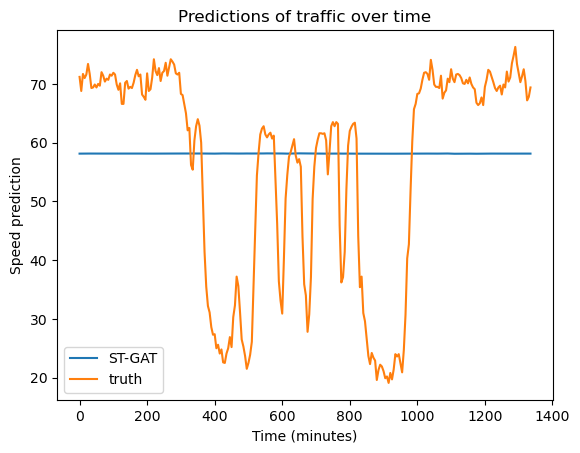

In [41]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[:config['N_SLOT']]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[:config['N_SLOT']]
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_truth, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed prediction')
    plt.title('Predictions of traffic over time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()
    
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')

plot_prediction(test_dataloader, y_pred, y_truth, 0, config)